# Ly$\alpha$ Luminosities

In [43]:
import sys
import glob
import numpy as np
import astropy.units as u
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import SymLogNorm
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const
from powerbox.powerbox import get_power
from hmf import MassFunction
from twentyonecmFAST import load_binary_data
from scipy.ndimage.filters import gaussian_filter
import xcorr

plt.rc('font', family='serif')

## Helpful Functions

In [44]:
def star_formation_rate(M, z = 7, sim_num = 1):
    '''
    Returns the star-formation rate for a dark-matter halo of a given mass and redshift
    
    Units: M_sun per year
    
    
    Note: Zero-out redshift for now. Other versions of this equation use redshift but the current
          sim that I am basing this equation off of does not use redshift.
    
    https://arxiv.org/pdf/1205.1493.pdf
    
    '''

    if sim_num == 1:
        a, b, d, c1, c2 = 2.8, -0.94, -1.7, 1e9, 7e10
        sfr = 2.8e-28 * (M ** a) * (1.0 + M / c1) ** b * (1.0 + M / c2) ** d
        
    if sim_num == 2:
        a, b, d, e, c1, c2, c3 = 2.59, -0.62, 0.4, -2.25, 8e8, 7e9, 1e11
        sfr = 1.6e-26 * (M ** a) * (1.0 + M / c1) ** b * (1.0 + M / c2) ** d * (1.0 + M / c3) ** e
        
    if sim_num == 3:
        a, b, d, e, c1, c2, c3 = 2.59, -0.62, 0.4, -2.25, 8e8, 7e9, 1e11
        sfr = 2.25e-26 * (1.0 + 0.075 * (z-7)) * (M ** a) * (1.0 + M / c1) ** b * (1.0 + M / c2) ** d * (1.0 + M / c3) ** e
    
    return sfr * u.M_sun / u.year

In [45]:
def f_lya(z, C_dust = 3.34, zeta = 2.57):
    '''
    Fraction of lyman-alpha photons not absorbed by dust
    
    https://arxiv.org/pdf/1010.4796.pdf
    '''
    return C_dust * 1e-3 * (1.0 + z) ** zeta

def f_esc(M,z):
    '''
    Escape fraction of ionizing photons
    '''
    def alpha(z):
        '''
        Alpha/beta values found in:

        https://arxiv.org/pdf/0903.2045.pdf
        '''
        zs = np.array([10.4,8.2,6.7,5.7,5.0,4.4])
        a = np.array([2.78e-2, 1.30e-2, 5.18e-3, 3.42e-3, 6.68e-5, 4.44e-5])
        b = np.array([0.105, 0.179, 0.244, 0.262, 0.431, 0.454])
        fa = interp1d(zs, a, kind = 'cubic')
        fb = interp1d(zs, b, kind = 'cubic')
        return (fa(z), fb(z))
    
    a, b = alpha(z)
    return np.exp(-a * M ** b)

def L_gal_rec(M, z, sim_num = 1):
    """
    Luminosity due to galactic recombinations
    """
    sf_rate = star_formation_rate(M, z = z, sim_num = sim_num)
    return 1.55e42 * (1 - f_esc(M, z)) * f_lya(z) * sf_rate * u.erg / u.s * u.year / u.Msun

def L_gal_exc(M, z, sim_num = 1):
    """
    Luminosity due to galactic excitations
    """
    sf_rate = star_formation_rate(M, z = z, sim_num = sim_num)
    return 4.03e41 * f_lya(z) * (1 - f_esc(M, z)) * sf_rate * u.erg / u.s * u.year / u.Msun

def L_gal(M, z, sim_num = 1):
    return L_gal_exc(M, z, sim_num = sim_num) + L_gal_rec(M, z, sim_num = sim_num)


def big_I(M, z, n = 256.):
    c = y(z) * cosmo.comoving_transverse_distance(z) ** 2 / (4 * np.pi * cosmo.luminosity_distance(z) ** 2)
    L_val = L_gal(M, z)
    V = (200. * u.Mpc / n) ** 3
    nu = 2.47e15 / u.s / (1 + z)
    return (nu * c * L_val / V).to(u.erg / u.cm ** 2 / u.s)

In [46]:
def H(z):
    '''
    Returns astropy Hubble constant at given redshift
    
    Units: km Mpc^-1 s^-1
    '''
    return cosmo.H(z)

def y(z):
    '''
    wl_lya -> Lyman-alpha wavelength in units of km
    
    Returns value in units of Mpc s
    '''
    l_lya = 1.215e-7 * u.m 
    return l_lya * (1.0 + z) ** 2 / H(z)

def I(z, L = L_gal, n = 5000, sim_num = 1):
    """ Mean Lyman Alpha Intensity
    """
    dlog10m = (13 - 8.) / n
    c = y(z) * cosmo.comoving_transverse_distance(z) ** 2 / (4 * np.pi * cosmo.luminosity_distance(z) ** 2)
    h = MassFunction(z = z, Mmin = 8, Mmax = 13, hmf_model = 'SMT', dlog10m = dlog10m)
    M = h.m * cosmo.h
    dM = np.diff(M)
    nu = 2.47e15 / u.s / (1 + z)
    dndm = h.dndm[1:] * u.Mpc ** -3
    nu_I = nu * np.sum(dndm * dM * L(M[1:], z, sim_num = sim_num) * c)
    return nu_I.to(u.erg / u.cm ** 2 / u.s)
    
def cube_3d_I(M, z, L = L_gal, n = 256):
    lya_field = np.zeros((n, n, n))
    I_vals = big_I(M, z, n = n).value
    lya_field[halo_pos[:, 0], halo_pos[:, 1], halo_pos[:, 2]] += I_vals
    return lya_field

In [47]:
def I_21(T, z):
    """
    Convert mean brightness temperature to a surface brightness
    """
    nu = 1420 * u.MHz / (z + 1)
    I = 2. * const.h * nu ** 3 / const.c ** 2 * 1.0 / (np.exp(const.h * nu / (const.k_B * T)) - 1)
    return (nu * I).to(u.erg / u.cm ** 2 / u.s)

In [48]:
z = 7.2
halos = np.loadtxt('../../data/halos_z7.20_768_200Mpc')
halo_pos = (halos[:, 1:] * 256).astype(int)
halo_mass = halos[:, 0]
idx = np.where(halo_pos[:, 2] == 127)[0]
lya_cube = cube_3d_I(halo_mass, z)

KeyboardInterrupt: 

In [ ]:
ps_Lya, k_Lya = get_power(lya_cube, 200, bins = 14, log_bins = True)
nu_I = I(z)

In [ ]:
f = '../../data/delta_T_v3_z007.20_nf0.283460_useTs1_256_200Mpc'
data_cube = load_binary_data(f)
dc = data_cube.reshape((256,256,256))

In [ ]:
ps_21, k_21, var = get_power(dc, 200, bins = 14, 
                        log_bins = True, dimensionless = True, get_variance=True)

delta = k_21 ** 3 * ps_21 / (2 * np.pi ** 2)
delta_dim = I_21(dc.mean() * u.mK, z) ** 2 * delta

In [ ]:
plt.figure(figsize=(10,6))
plt.errorbar(k_21, k_21 ** 3 * ps_21, yerr = k_21 ** 3 * np.sqrt(var), color = 'lightblue', ecolor = 'k',
             fmt = 'o', capsize=2, elinewidth=1)
plt.xscale('log')
plt.yscale('log')
plt.ylim([10, 1e4])
plt.show()

In [ ]:
x_power, k = get_power(lya_cube, 200, deltax2 = dc, dimensionless=True,
                       log_bins = True, bins = 14)
delta_x = k ** 3 * x_power / (2 * np.pi ** 2)
delta_dim_x = I_21(dc.mean() * u.mK, z) * nu_I * delta_x

In [ ]:
delta_lya = nu_I ** 2 * ps_Lya * k_Lya ** 3 / (2 * np.pi ** 2)

In [ ]:
#np.save('ccc_{}'.format(z), np.array(delta_dim_x / np.sqrt(delta_dim * delta_lya)))

In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(k, delta_dim_x / np.sqrt(delta_dim * delta_lya), color = 'darkorange')
plt.ylim([-1, 1.5])
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel(r'$\Delta ({\rm k})$ [erg/s/cm$^2$/sr]')
plt.xscale('log')
plt.grid()
plt.show()

## Diffuse IGM Emission

In [49]:
def n_rec_dot(T_k, x, delta_x, z):
    """
    """
    return alpha(T_k, z) * n_e(x, delta_x, z) * n_HII(x, delta_x, z)

def n_e(x, delta_x, z):
    """
    """
    return x * n_b(delta_x, z)

def n_b(delta_x, z, n_b0 = 1.905e-7 * u.cm ** -3):
    """
    """
    return delta_x * (1 + z) ** 3 * n_b0

def n_HII(x, delta_x, z, Y_He = 0.24):
    """
    """
    return n_e(x, delta_x, z) * (4. - 4. * Y_He) / (4. - 3 * Y_He)

def alpha(T_k, z):
    """
    Recombination coefficient
    """
    #T_k = 1e4
    units = u.cm ** 3 / u.s
    return 4.2e-13 * (T_k / 1e4) ** -0.7 * (1 + z) ** 3 * units

def L_diffuse(T_k, x, delta_x, z, f_rec = 0.66):
    """
    """
    E_lya = 1.637e-11 * u.erg
    return f_rec * n_rec_dot(T_k, x, delta_x, z) * E_lya

def I_diffuse(T_k, x, delta_x, z):
    """
    """
    c = y(z) * cosmo.comoving_transverse_distance(z) ** 2 / (4 * np.pi * cosmo.luminosity_distance(z) ** 2)
    nu = 2.47e15 / u.s / (1 + z)
    return (L_diffuse(T_k, x, delta_x, z) * c * nu).to(u.erg / u.cm ** 2 / u.s)

In [53]:
cosmo.comoving_transverse_distance(z) / cosmo.angular_diameter_distance(z) - 1.

<Quantity 6.>

In [ ]:
delta_x = load_binary_data('../../data/updated_smoothed_deltax_z007.20_256_200Mpc')
delta_x = np.reshape(delta_x, (256, 256, 256))

T_k = load_binary_data('../../data/Ts_z008.06_L_X3.2e+40_alphaX1.0_f_star0.0500_alpha_star0.5000_f_esc0.1000_alpha_esc-0.5000_Mturn5.0e+08_t_star0.5000_Pop2_256_200Mpc')
T_k = np.reshape(T_k, (256, 256, 256))

x_i = load_binary_data('../../data/xH_z007.04_nf0.233584_Fstar0.0500_starPL0.5000_Fesc0.1000_escPL-0.5000_Mturn5.00e+08_HIIfilter1_RHIImax50_256_200Mpc')
x_i = np.reshape(x_i, (256, 256, 256))



In [ ]:
diff_cube = I_diffuse(T_k, 1 - x_i, delta_x, z = 8.06) 

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.imshow(gaussian_filter(diff_cube[:, :, 128].value, 0.5), norm = SymLogNorm(1e-9, vmax = 3e-7), cmap = 'inferno')

plt.subplot(122)
plt.imshow(lya_cube[:, :, 128], norm = SymLogNorm(1e-8, vmax = 1e-6), cmap = 'inferno')

plt.show()

In [42]:
ccc_dif, k = xcorr.r(diff_cube, dc, 200, bins = 14, log_bins = True)
ccc_lya, k = xcorr.r(lya_cube, dc, 200, bins = 14, log_bins = True)
ccc_both, k = xcorr.r(lya_cube + diff_cube.value, dc, 200, bins = 14, log_bins = True)

NameError: name 'cube' is not defined

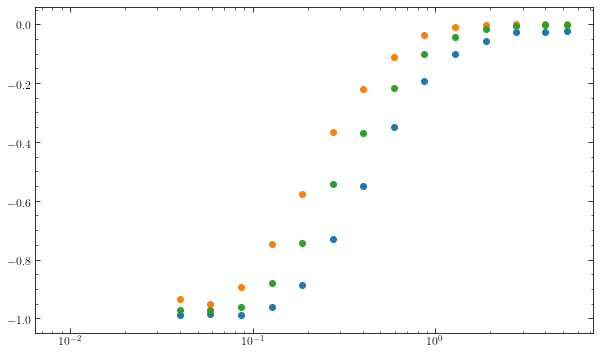

In [21]:
plt.figure(figsize = (10, 6))
plt.scatter(k, ccc_dif)
plt.scatter(k, ccc_lya)
plt.scatter(k, ccc_both)
plt.xscale('log')
plt.show()

In [41]:
plt.figure(figsize = (10, 6))
plt.scatter(k, (ccc_dif + ccc_lya) / 2.)
plt.scatter(k, ccc_both)
plt.xscale('log')
plt.ylim([-1, 1])
plt.show()

NameError: name 'ccc_dif' is not defined

<Figure size 720x432 with 0 Axes>

## Scattered IGM Emission

In [ ]:
def 